# Thema 3 werkcollege 4: Large Language Models
Het trainen van transformer (taal)modellen is een rekenintensieve langdurige gelegenheid die ook nog eens fikse datasets vereist. Gelukkig hoef je dit niet altijd helemaal zelf te doen. In deze les gaan we naar meerdere voorbeelden kijken van pretrained networks. Hiervoor maken we gebruik van de library kerasnlp. Dit pakket is een uitbreiding van Keras waarin een groot aantal voorgetrainde netwerken beschikbaar is. Het doortrainen van een netwerk op een specifieke usecase wordt transfer learning genoemd.

Op BrightSpace heb je gelezen dat er verschillende soorten transformermodellen zijn: encoder-only, decoder-only en encoder-decoder modellen. Enkele van de meest bekende modellen zijn de encoder [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) (Bidirectional Encoder Representations from Transformers), en de decoder [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) (Generative pre-trained transformers ). 

<figure>
    <img src="encoderdecoder.png" width="500" height="300" />
     <figcaption style="font-style: italic;">source: <a href="https://deeplearning.ai">deeplearning.ai</a></figcaption>
</figure>

Tijdens dit werkcollege gaan we daarom met BERT en GPT-2 werken.

## Data Preparation
Tijdens deze les werken we weer met de game_review data. Als eerste beginnen we weer met het inlezen en prepareren van de game_review data.

In [1]:
#lees de reviewdata in en zet deze om naar tf data-objecten (gegeven, zie vorige les)
import pandas as pd
df= pd.read_excel('gamereviews.xlsx')
text=df['reviewText'].astype('str')
sentiment=df['sentiment'].astype('int')
print(text.head())
print(sentiment.head())
print(sentiment.sum())

0    If you're looking for immersive gameplay, good...
1    The zippers on this bag are terrible. I ordere...
2    If you need a good intro to Wii games, this is...
3    This game has brought back so many great memor...
4    True Crime: Streets of LA was my first experie...
Name: reviewText, dtype: object
0    0
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int64
50000


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
#gegeven, zie vorige les
train_features, test_features, train_targets, test_targets = train_test_split(
        text, sentiment,
        test_size=0.2,
        shuffle = True,
        stratify=sentiment
    )

In [4]:
#gegeven, zie vorige les
import tensorflow as tf

#omzetten naar tensorflow dataobject met een batch_size van 64
#NB meer infor voor de docent https://www.geeksforgeeks.org/difference-between-dataset-from_tensors-and-dataset-from_tensor_slices/
train_text = tf.data.Dataset.from_tensor_slices(tf.cast(train_features.values, tf.string)).batch(64) #default batch is 32
train_cat = tf.data.Dataset.from_tensor_slices(tf.cast(train_targets.values, tf.int64)).batch(64)  
test_text = tf.data.Dataset.from_tensor_slices(tf.cast(test_features.values, tf.string)).batch(64)  
test_cat = tf.data.Dataset.from_tensor_slices(tf.cast(test_targets.values, tf.int64)).batch(64)   

for each in train_text.take(1): #toon de 1e review
  print(each)

2024-10-07 06:58:55.309477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 06:58:55.327089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 06:58:55.332087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 06:58:55.345163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1728284336.894010     999 cuda_executor.c

tf.Tensor(
[b"The picture shows a  disc that was supposed to be included. It was not and by looking at other reviews I am not alone. You should change your description or change the picture. I haven't decided if it's worth packaging it and taking it to a ups drop off or not."
 b"Wanted to get something to protect the new 3DSXLs and this does fit, but the cover moves over the keys and the kids didn't like them. Asked me to take them off.\nHoping Nerf comes out with another case like it did for the DS. We loved those. This was $4 with shipping, at least it was worth a shot...."
 b"This is a cheap chunk of garbage,only star wars fans would defend this game with their light saber & Darth Vader robe costume on while typing @(someone's name) on how they disagree. \nDevelopers are getting extremely lazy,if we let them continue doing this we will receive trailers priced at 60$ next.\nBasically this is a map pack with other map packs soon to be released in the season pass. Smell the coffee  thi

2024-10-07 06:58:58.169897: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
#samenvoegen naar 1 train en test dataset (gegeven, zie vorige les)
train_ds = tf.data.Dataset.zip((train_text,train_cat)) 
test_ds = tf.data.Dataset.zip((test_text,test_cat)) 

for each in train_ds.take(1): #toon de 1e batch
  print(each)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"The picture shows a  disc that was supposed to be included. It was not and by looking at other reviews I am not alone. You should change your description or change the picture. I haven't decided if it's worth packaging it and taking it to a ups drop off or not.",
       b"Wanted to get something to protect the new 3DSXLs and this does fit, but the cover moves over the keys and the kids didn't like them. Asked me to take them off.\nHoping Nerf comes out with another case like it did for the DS. We loved those. This was $4 with shipping, at least it was worth a shot....",
       b"This is a cheap chunk of garbage,only star wars fans would defend this game with their light saber & Darth Vader robe costume on while typing @(someone's name) on how they disagree. \nDevelopers are getting extremely lazy,if we let them continue doing this we will receive trailers priced at 60$ next.\nBasically this is a map pack with other map packs soon 

2024-10-07 06:58:58.197035: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Encoder-only transformers: Sentimentanalyse met BERT
Dan nu ons 1e BERT model. Zoals hierboven als gesteld is bevat BERT alleen een encoder deel van een transformer en ontbreekt de decoder. Globaal gezien ziet dit er als volgt uit. 

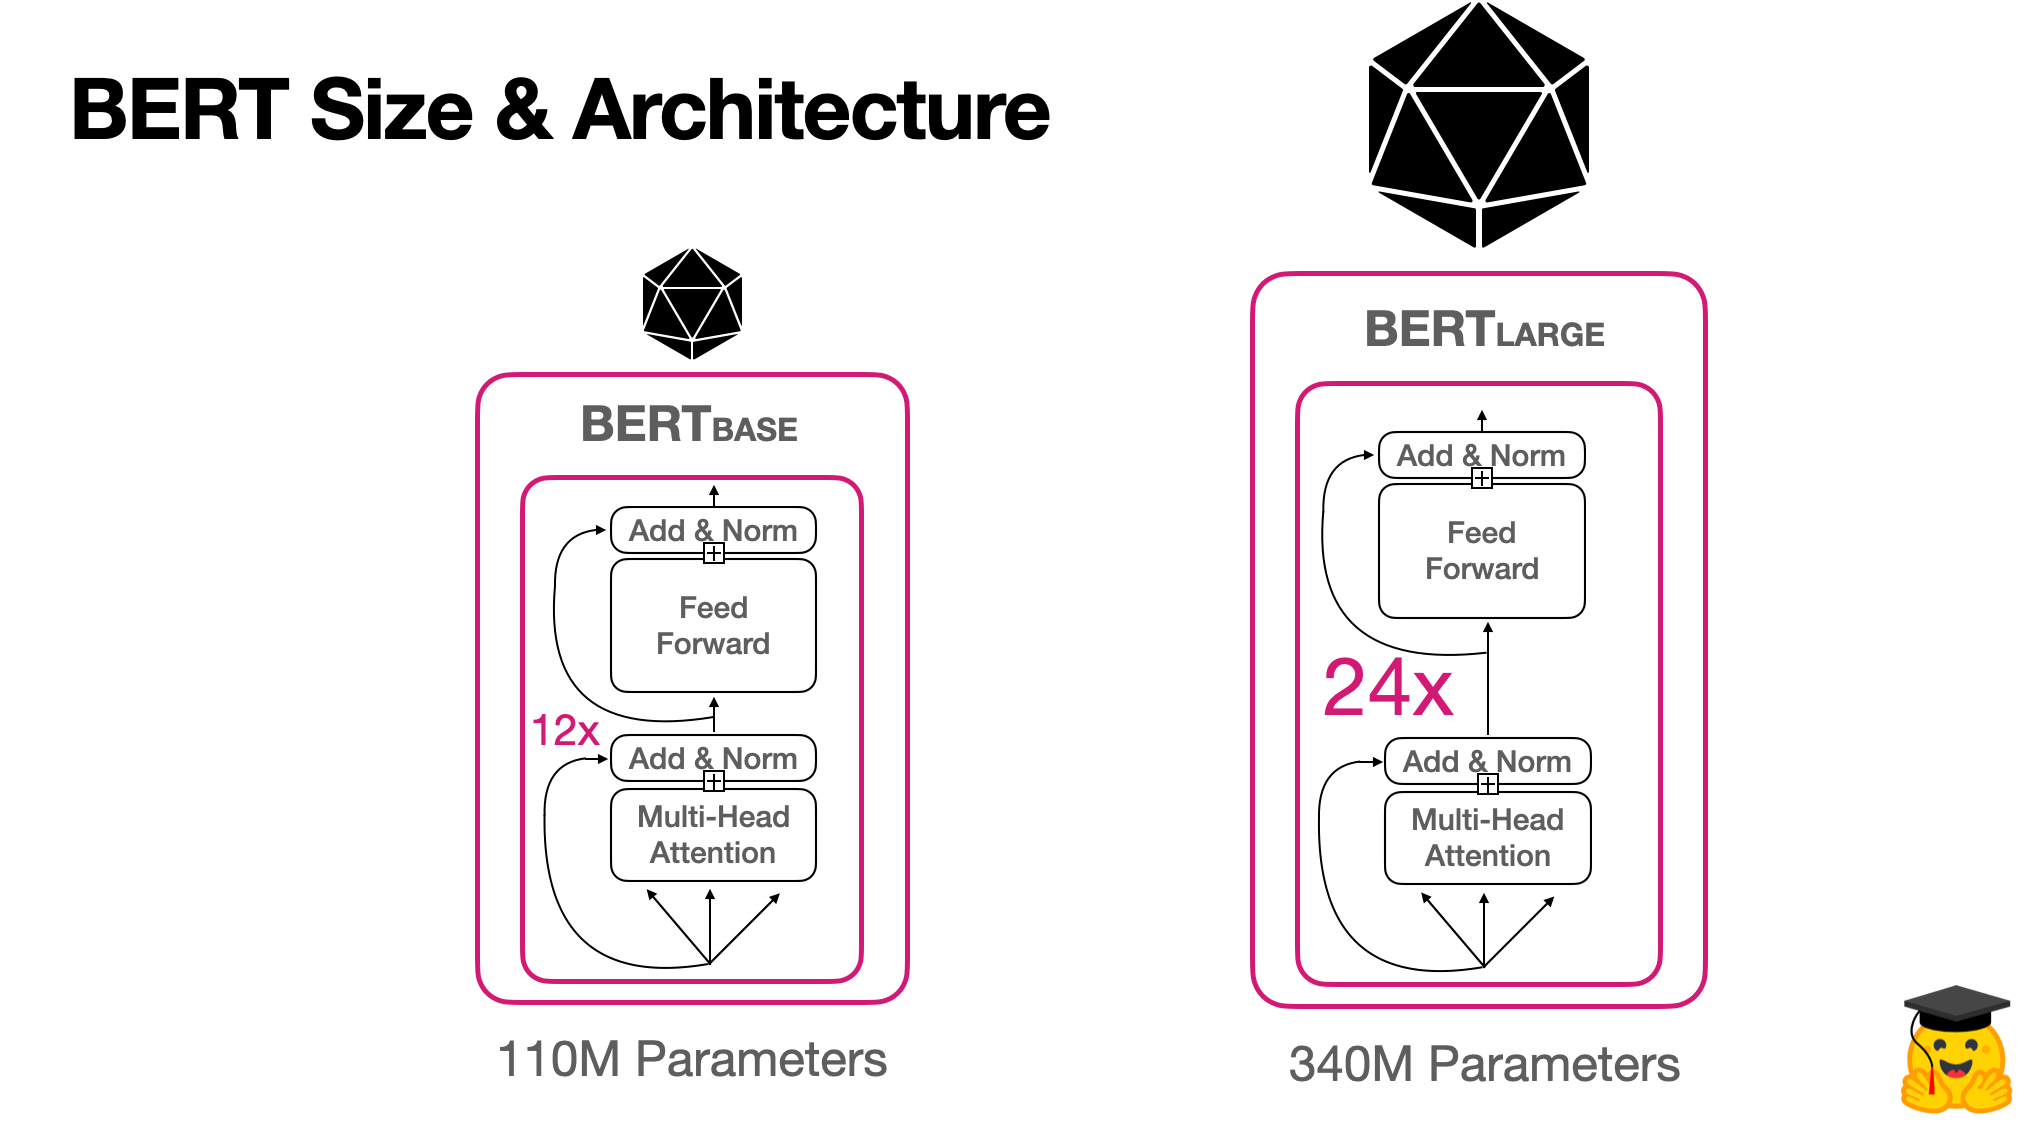 source: https://huggingface.co/blog/bert-101

Zoals je ziet lijkt dit heel erg op in de vorige les behandelde encoder deel van de transformer. Alleen kent deze wat meer transformerblocks en is al voorgetraind.  Dit laatste is natuurlijk heel handig ivm de beschikbare tijde en rekenkracht


Op https://keras.io/api/keras_nlp/models/bert/ staat een hele uitleg over hoe je BERT kunt gebruiken. Kort gesteld hebben we een backbone wat het eigenlijk BERT model bevat en een aantal voorgedefineerde variaties erop die het leven een stukje makkelijker maken. Zo bestaat er o.a. een voorgedefineerd BERT model voor classificatie. Dit bevat de BERT backbone met een extra dropout en dense layer voor het classificatiedeel. In deze les maken we het ons zelf wat moeilijker en gebruiken we alleen de backbone (het originele BERT-model) en voegen we zelf een aantal layers die we nodig hebben voor de classificatie toe. 

NB: Beperk je ivm de performance tot "bert_tiny_en_uncased". 

In [6]:
#Laad het BERT model en geef de summary

#!pip install keras_nlp
import keras_nlp

bert = keras_nlp.models.BertBackbone.from_preset(
    "bert_tiny_en_uncased"
)
bert.summary()

Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 128) │  3,906,816 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 128) │     65,536 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_embedding   │ (None, None, 128) │        256 │ segment_ids[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 128) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
│                     │                   │            │ segment_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 128) │        256 │ embeddings_add[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 128) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 128) │    198,272 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 128) │    198,272 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ transformer_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_dense        │ (None, 128)       │     16,512 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,385,920 (16.73 MB)

 Trainable params: 4,385,920 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

Wat kun je over de achitectuur van het model zeggen?

[ANTWOORD] We zien voor veel van het plaatje terug, alleen hebben we in dit geval maar 2 transformer layers ipv 12 of 24


## BERT Finetunen
We hebben nu een voorgetraind BERT-model geladen wat een goede kennis heeft van de engelse taal, maar hiermee kunnen we nog geen sentimenten gaan voorspellen. Hiervoor moeten we BERT nog gaan finetunen op onze specifieke situatie.

Over het algemeen bestaat finetuning uit de volgende stappen: 

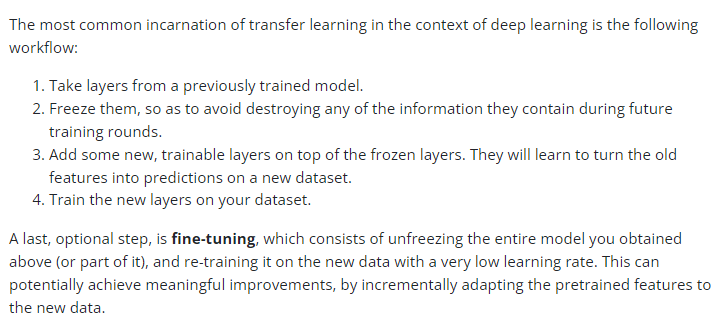

Bron: https://keras.io/guides/transfer_learning/

In [7]:
# set het Bert model op trainable=false en geef opnieuw de summary (kijk vooral naar verschillen met hierboven)
bert.trainable=False
bert.summary()

Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 128) │  3,906,816 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 128) │     65,536 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_embedding   │ (None, None, 128) │        256 │ segment_ids[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 128) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
│                     │                   │            │ segment_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 128) │        256 │ embeddings_add[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 128) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 128) │    198,272 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 128) │    198,272 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ transformer_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_dense        │ (None, 128)       │     16,512 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,385,920 (16.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,385,920 (16.73 MB)

[ANTWOORD] we zien dat het aantal trainable parameters naar 0 is gegaan

In [8]:
#laad de Bert preprocesser en map onze train en test dataset hierop zie https://keras.io/guides/keras_nlp/getting_started/ Fine tuning with user-controlled preprocessing
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_tiny_en_uncased", sequence_length=512)
train_ds_preprocessed = (
    train_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE) #autotune iets met automatisch bepalen buffergrootte e.d.
)
test_ds_preprocessed = (
    test_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

In [9]:
# voeg een dropout en een dense-layer toe zie bijv https://keras.io/guides/keras_nlp/getting_started/ kopje Fine tuning with a custom model
#from tensorflow import keras
import keras
inputs = bert.input
x = bert(inputs)["sequence_output"] 
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(2)(x[:, bert.cls_token_index, :])
# # voor meer info over het CLS token zie https://datascience.stackexchange.com/questions/66207/what-is-purpose-of-the-cls-token-and-why-is-its-encoding-output-important
# x[:, bert.cls_token_index, :] selecteert een specifieke deelverzameling van deze tensor:
# : (de eerste positie) betekent dat we alle voorbeelden in de batch selecteren.
# bert.cls_token_index geeft de positie van het [CLS] token aan, dat vaak wordt gebruikt als de representatie van de volledige zin in een BERT-model.
# : (de laatste positie) betekent dat we alle waarden (features) voor het [CLS] token selecteren.
# Dit stuk code haalt dus de representatie van het [CLS] token voor alle voorbeelden in de batch uit de tensor x.
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 128) │          0 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128)       │          0 │ dropout_2[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        258 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 4,385,920 (16.73 MB)

In [10]:
#compile het model (copy paste uit het voorbeeld in de keras documentatie, apple silicon Adam ipv Adamw)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()], #dus straks ook andere plots
    jit_compile=True,
)

In [11]:
# fit de dataset (5 epochs)
history=model.fit(train_ds_preprocessed, epochs=5, validation_data=test_ds_preprocessed)

Epoch 1/5


I0000 00:00:1728284344.640338    2685 service.cc:146] XLA service 0x7fc7c0012700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728284344.640497    2685 service.cc:154]   StreamExecutor device (0): Quadro RTX 3000, Compute Capability 7.5
2024-10-07 06:59:04.762939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 06:59:05.198766: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 2:58:34 9s/step - loss: 1.5899 - sparse_categorical_accuracy: 0.4531

I0000 00:00:1728284350.499902    2685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - loss: 1.1052 - sparse_categorical_accuracy: 0.4908 - val_loss: 0.7245 - val_sparse_categorical_accuracy: 0.5541
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.8198 - sparse_categorical_accuracy: 0.5480 - val_loss: 0.6240 - val_sparse_categorical_accuracy: 0.6526
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.7131 - sparse_categorical_accuracy: 0.6034 - val_loss: 0.5728 - val_sparse_categorical_accuracy: 0.7032
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.5454 - val_sparse_categorical_accuracy: 0.7307
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.6151 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.5292 - val_sparse_categorical_accuracy: 0.7444


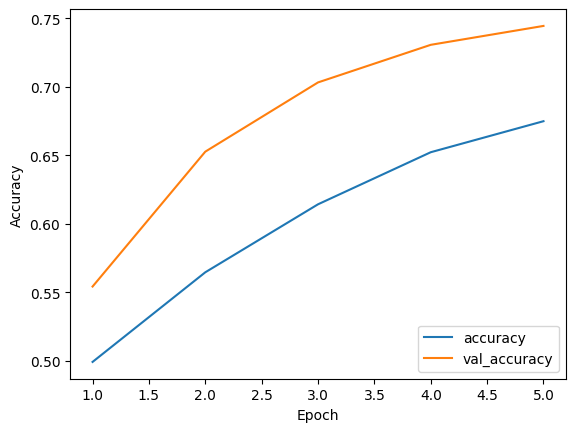

In [12]:
#plot de accuracy en val accuracy 

#opmerking:laat ze zelf maar uitpluizen dat ze de sparse_categorical_accuracy en val_sparse_categorical_accuracy moeten hebben
import matplotlib.pyplot as plt
#history.history
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Wat kun je zeggen over de resultaten?

[ANTWOORD] We zien dat we dit zeer complexe model op deze manier redelijk snel kunnen trainen en ook al snel een redelijk hoge validated accuracy weten te behalen.

Nu zijn de resultaten nog niet helemaal zo hoog als we zouden willen. Een mogelijke verklaring is dat dit komt doordat (game) reviews een aantal specifieke termen bevatten waar ons tiny_bert model nog niet goed op is getraind. Daarom voegen we als extra een (trainbare) transformer encoder toe voor onze dropout layer. Volg het voorbeeld op https://keras.io/guides/keras_nlp/getting_started/ maar dan 1 transformerencoder en zonder dropout.

In [13]:
#pas het model aan met 1 transformer encoder
inputs = bert.input
x = bert(inputs)["sequence_output"] 
x= keras_nlp.layers.TransformerEncoder(num_heads=2, intermediate_dim=512)(x)
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(2)(x[:, bert.cls_token_index, :])
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    198,272 │ bert_backbone[1]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128)       │          0 │ dropout_4[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ get_item_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,584,450 (17.49 MB)

 Trainable params: 198,530 (775.51 KB)

 Non-trainable params: 4,385,920 (16.73 MB)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step - loss: 0.6633 - sparse_categorical_accuracy: 0.6581 - val_loss: 0.4260 - val_sparse_categorical_accuracy: 0.8045
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - loss: 0.4523 - sparse_categorical_accuracy: 0.7912 - val_loss: 0.3785 - val_sparse_categorical_accuracy: 0.8304
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - loss: 0.4115 - sparse_categorical_accuracy: 0.8130 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.8418


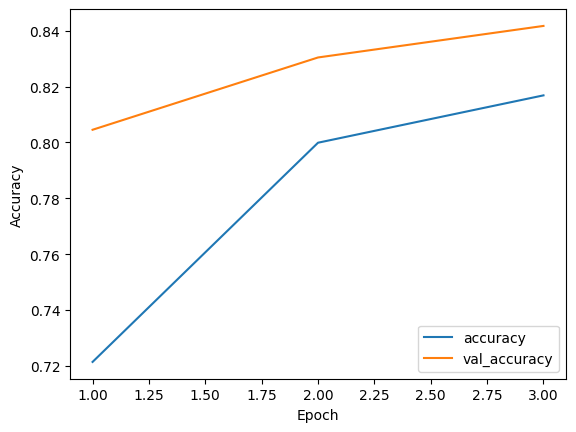

In [14]:
#compile, fit (epochs=3) en plot de accuracy en validated accuracy
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
history=model.fit(train_ds_preprocessed, epochs=3, validation_data=test_ds_preprocessed)
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Heeft dit veel effect?
[Antwoord] we zien dat het toevoegen van een enkele transformerencoder onze resulten zelfs na 3 epochs al flink ophoogt

We hebben nu een stukje transferlearning toegepast waarbij we de voorgetrainde BERT backbone hebben gebruik en de extra classificatielayers er omheen hebben getraind. Nu wordt er in het bovengenoemde stappenplan ook gesproken over een optionele extra stap, namelijk het opnieuw trainen van het hele model met een heel lage learning rate.  Wees hier wel heel voorzichtig mee want we lopen een groot risico alles wat ons BERT-model pretrained meebracht meteen weer kwijt te raken. Om dit te voorkomen zijn er aan aantal dingen van belang: 
1. Ten eerste trainen we met een ***hele lage learning rate*** zodat we niet te snel alle bestaande weights allemaal overschrijven. 
2. We ***beperken ons aantal epochs*** tot niet meer dan een paar
3. We ***setten training=False***. We hadden al trainable=False gezien wat ervoor zorgde dat we de backbone niet konden trainen. trainable=False doet net iets anders, dit zorgt er namelijk voor dat we alleen de dropout en batchnormalisation layers niet kunnen trainen)


In [15]:
# set de bert backbone op trainbaar, maar set trainig op False en geef de summary. Check het aantal trainbare parameters
bert.trainable=True #unfreeze de backbone
bert.training=False #bevries alle dropout en normalisation layers
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 128),     │  4,385,920 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 128)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    198,272 │ bert_backbone[1]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128)       │          0 │ dropout_4[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ get_item_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,981,512 (19.00 MB)

 Trainable params: 4,584,450 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 397,062 (1.51 MB)

In [16]:
#Compile het model met een lage learning rate (5e-5)en fit het hele BERT model op onze dataset (epochs=1). 
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
history=model.fit(train_ds_preprocessed, epochs=1, validation_data=test_ds_preprocessed)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 112ms/step - loss: 0.3305 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.2009 - val_sparse_categorical_accuracy: 0.9204


Wat kun je zeggen over de resultaten?

[ANTWOORD] Door ons BERT-model (backbone) te unfreezen en nogmaals te trainen zien we dat het trainen veel meer tijd kost. DIt is niet zo gek want we hebben opeens veel meer trainbare paremeters. We zien ook onze validated accuracy flink is gestegen. We zitten nu zelf boven de resultaten van de vorige les 

NB: We hebben natuurlijk ook nog een epoch getraind, dus daar kan een deel van de winst ook nog uitkomen. 

In [17]:
# Opruimen voordat we naar het nieuwe onderdeel gaan
del model
del history
del bert

## Decoder-only modellen: Sentimentanalyse met GPT-2
We hebben nu gekeken naar een encoder-only model: BERT. Kenmerkend aan dit model is dat er discrete output neuronen zijn die gebruikt kunnen worden om mee te classificeren. 

In het tweede deel van dit werkcollege gaan we kijken naar generatieve oplossingen. Daar vallen zowel de encoder-decoder als de decoder-only modellen onder. Bij een encoder-decoder model geef je een prompt, waarna het model een nieuwe output genereert. Bij een decoder model geef je ook een prompt, maar breidt het model de prompt uit met extra woorden: de completion. 

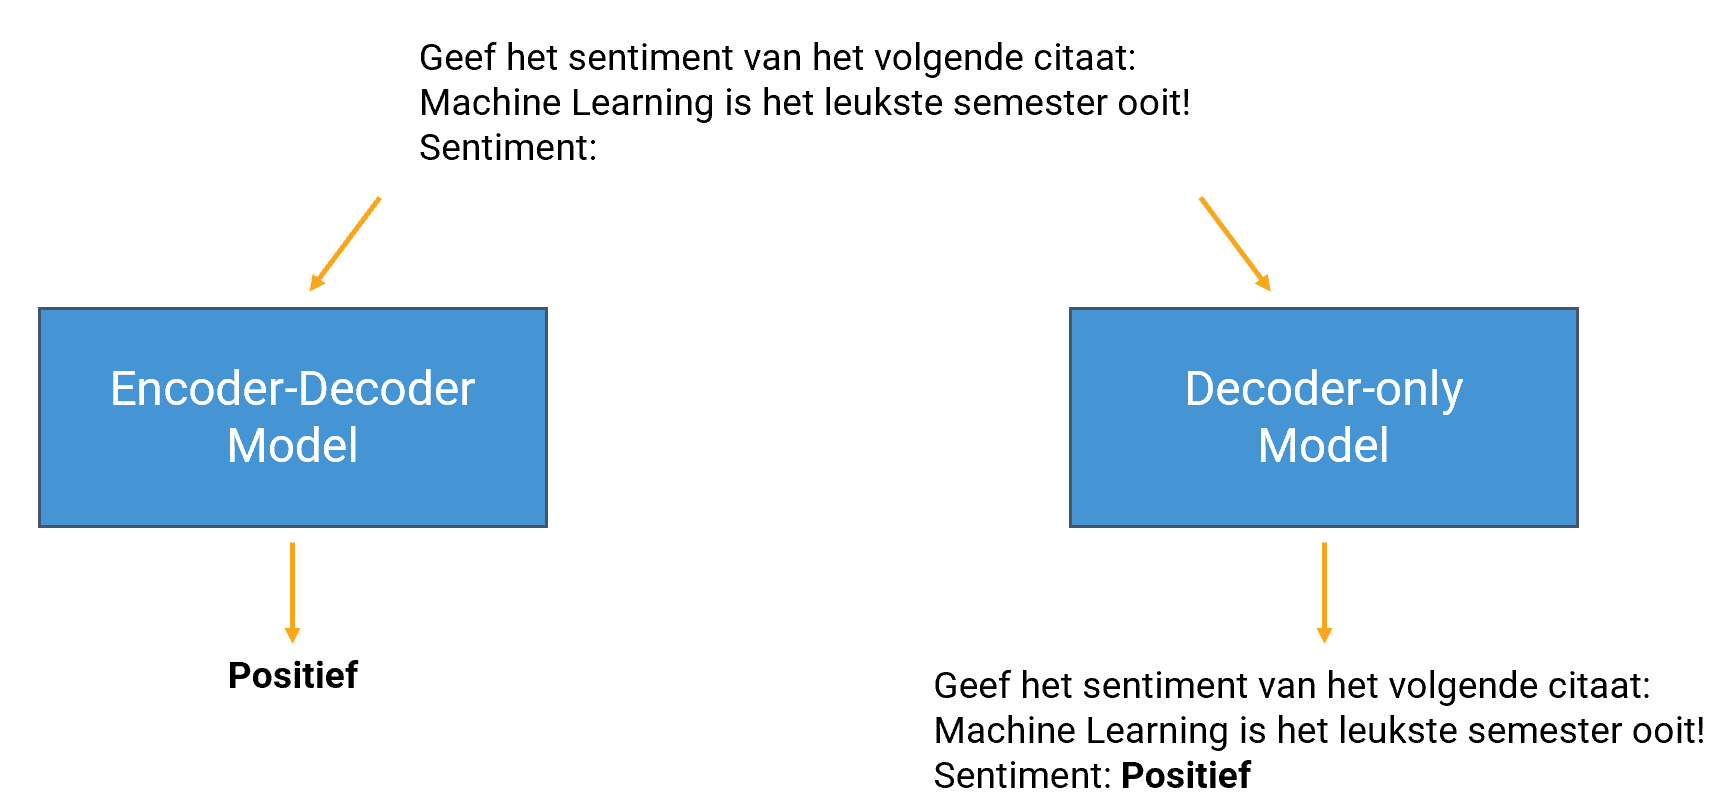

### Model
In deze les kijken we naar het GPT-2 model. Dit is een decoder-only model. 

Als eerste halen we het model op

In [18]:
#from tensorflow import keras
import keras
policy = keras.mixed_precision.Policy("mixed_float16") # Beperk het geheugengebruik van je model
keras.mixed_precision.set_global_policy(policy)

import keras_nlp
import tensorflow as tf
import pandas as pd

In [19]:
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=100,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor
)

Bekijk onderstaand model. Hoeveel transformerlagen zitten er in het GPT2 model?

In [20]:
gpt2_lm.backbone.summary()

Model: "gpt2_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None,      │ 38,597,376 │ token_ids[0][0]   │
│ (ReversibleEmbeddi… │ 50257)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    786,432 │ token_embedding[… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_add      │ (None, None, 768) │          0 │ token_embedding[… │
│ (Add)               │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 768) │          0 │ embeddings_add[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 768) │  7,087,872 │ embeddings_dropo… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_6 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_7 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_8 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_9 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerDecode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

### Dataset
We gaan opnieuw aan de slag met de dataset over gamedata. Importeer de data uit de file en maak een dataframe waarin er één kolom 'fulltext' is met de hele text van de review en één kolom met het sentiment. Beperk je tot 500 samples.

In [21]:
def get_dataset(N=500):
    df = pd.read_excel('gamereviews.xlsx')
    text = df['reviewText'].astype('str')
    sentiment = df['sentiment'].astype('int')
    return pd.DataFrame({'fulltext': text[:N].values, 'sentiment': sentiment[:N].values})

df = get_dataset()
df.head(2)

,fulltext,sentiment
0,"If you're looking for immersive gameplay, good...",0
1,The zippers on this bag are terrible. I ordere...,0


We maken een _template_ om een opdracht mee te geven aan het model. Dit passen we vervolgens toe op de dataset. We maken daarbij twee datasets: een inclusief het antwoord en een zonder het antwoord.

In [22]:
template = "Classify the sentiment:\n{0}\nSentiment:{1}"

In [23]:
# Encode to tokens, limit to 60 and decode back
ds = gpt2_lm.preprocessor.generate_postprocess(preprocessor(df['fulltext'].astype(str), sequence_length=60)[0])

# Create the instructions for the prompt: one including the completion, one without
# ds_with_completion = [template.format(sentence.numpy().decode('utf-8'), " Positive" if label==1 else " Negative") for sentence, label in zip(ds, df['sentiment'])]
# ds_without_completion = [template.format(sentence.numpy().decode('utf-8'), "") for sentence, label in zip(ds, df['sentiment'])]
ds_with_completion = [template.format(sentence, " Positive" if label==1 else " Negative") for sentence, label in zip(ds, df['sentiment'])]
ds_without_completion = [template.format(sentence, "") for sentence, label in zip(ds, df['sentiment'])]


# De lijst wordt gemaakt met een list comprehension, wat een kortere manier is om een lijst te vullen op basis van een iteratie. Het gedeelte binnen de vierkante haken [] genereert een nieuw element voor de lijst, door elk sentence en bijbehorende label in de zip(ds, df['sentiment']) te verwerken.
# zip(ds, df['sentiment']):

# De zip() functie koppelt twee lijsten of series aan elkaar (in dit geval ds en df['sentiment']).
# Hierbij koppelt zip() het eerste element van ds aan het eerste element van df['sentiment'], het tweede element van ds aan het tweede element van df['sentiment'], enzovoort. Dit levert telkens een sentence en een label op.
# template.format(sentence, " Positive" if label==1 else " Negative"):

# Hier wordt de format() methode gebruikt om een sentence te formatteren met een bijbehorende beoordeling ("Positive" of "Negative").
# template is een string met placeholders die de zin en het sentimentbeoordeling op een bepaalde manier combineert (bijvoorbeeld "{},{}").
# De tweede parameter voor format() kiest tussen " Positive" en " Negative" op basis van de waarde van label:
# Als label == 1, voegt het " Positive" toe aan de zin.
# Als label != 1 (waarschijnlijk 0), voegt het " Negative" toe aan de zin.
# Resultaat ds_with_completion:

# Elke zin (sentence) wordt gecombineerd met een label (zoals " Positive" of " Negative") en toegevoegd aan de lijst ds_with_completion.

In [24]:
print(ds_with_completion[0])

Classify the sentiment:
If you're looking for immersive gameplay, good story and graphics...then don't buy this game.  At first I thought this would be a Max Payne knock-off, which would be fine because that was a great game.  Unfortunately this game can't even be put into the same category
Sentiment: Negative


In [25]:
print(ds_without_completion[0])

Classify the sentiment:
If you're looking for immersive gameplay, good story and graphics...then don't buy this game.  At first I thought this would be a Max Payne knock-off, which would be fine because that was a great game.  Unfortunately this game can't even be put into the same category
Sentiment:


Splits als laatste je data in train en testsamples. Je mag 10% overhouden voor testen.

In [26]:
ds_with_completion_train, ds_with_completion_test, ds_without_completion_train, ds_without_completion_test = train_test_split(ds_with_completion, ds_without_completion, test_size=0.1)

### Prompt Engineering
We gaan als eerste kijken hoe het model zich gedraagt als we nog niks getraind hebben. De hoop is daarbij dat het model genoeg voorkennis heeft om het goed te doen. Geef daarvoor het eerste record uit de dataset (zonder completion) aan het model en kijk hoe het zich gedraagt:

In [27]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def infer_and_print(model, prompt, max_length=100) -> None:
    """Infer the result based on the prompt. Print the output in boldfaced."""
    
    inference = model.generate(prompt, max_length = max_length)

    print(prompt, color.BOLD, inference[len(prompt):], color.END)


In [28]:
prompt = ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt)

Classify the sentiment:
Couldn't get it to work in my computer.
Sentiment:  
I'm not sure what to think about this.
Sentiment:
This is a very interesting question.
I don't think this is the best idea.
I'm not sure what to do.
Sentiment:
This is not a good idea, I can't think of any other ideas.
Sentiment:
This is not a good idea I'm not 


Hoe goed presteert je model?
[Antwoord] Het model produceert wel tekst, maar zoals je kunt zien nog niet in het gewenste formaat met enkel 'positive' of 'negative' als antwoord. Bij zero-shot inference krijgen we dus niet het gewenste antwoord. 

Probeer daarom in je prompt nu één of meerdere voorbeelden mee te geven van correcte antwoorden, voordat je het definitieve model geeft

In [29]:
# One-shot inference
prompt = ds_with_completion_test[1] +'\n\n' + ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt, 200)

Classify the sentiment:
I wasn;t impressed with these at all.  Flimsy don't let the cute frog pattern fool you.  I used to bet better quality ones from another outfit.
Sentiment: Negative

Classify the sentiment:
Couldn't get it to work in my computer.
Sentiment:  

This is not what I thought it'd be.
Sentiment:

This is the best outfit. 


In [30]:
# Few shot inference
prompt = ds_with_completion_test[1] + '\n\n' + ds_with_completion_test[2] + '\n\n' + ds_without_completion_test[0]
infer_and_print(gpt2_lm, prompt, 300)

Classify the sentiment:
I wasn;t impressed with these at all.  Flimsy don't let the cute frog pattern fool you.  I used to bet better quality ones from another outfit.
Sentiment: Negative

Classify the sentiment:
Let me start by saying this is the best product I've ever purchased. Only $107.89 for 6 amazing great quality guides in a well built chest and a golden bookmark. These are top notch guides, well written, and well put together!
HEADS UP: There's only 50
Sentiment: Positive

Classify the sentiment:
Couldn't get it to work in my computer.
Sentiment:   Positive.  It's great.  The colors are great and the quality and design is excellent.  I love how the design is simple, and the colors match up well with the color.  I'm very pleased with how well they're made out.  They've been on my computer for about 6 months.
I've used them in a few different projects.  The first time I used them was on my desk in my office in the middle of the night when I had to get a new computer.  I'm sure i

Wat is nu de kwaliteit van je model?
[ANTWOORD] Zoals je kunt ziet geeft prompt engineering je de kans om het model in de goede richting te duwen zonder dat het model getraind hoeft te worden. Helaas zijn de resultaten nog niet heel consistent (probeer het model maar eens opnieuw te draaien) en blijft het extra output genereren. Het model 'hallucineert' en verzint compleet nieuwe prompt vragen! 

Laten we nu gaan kijken of we door middel van fine-tuning het model beter kunnen maken.

### Finetunen van het hele model
We geven alvast wat instellingen weg om goed te kunnen doortrainen met het model. Belangrijkste aspect in onderstaande is dat de learning rate erg laag is. Was deze hoger, dan zou het model erg snel het al geleerde vergeten.

In [31]:
# We maken gebruik van het AdamW algoritme in plaats van Adam. Dit is een net iets efficienter model voor deze taak.
# De parameters zijn de aanbevolen instellingen voor het finetunen van een LLM.
optimizer = keras.optimizers.AdamW( #adamw is Adam plus weigth decay
    learning_rate=1e-5, #kleien lr default 1e-3
    weight_decay=0.01, #een regularisatietechniek die bedoeld is om overfitting te voorkomen door een penalty toe te voegen voor grote gewichten.
    epsilon=1e-6, #beschermt tegen delingen door 0.
    global_clipnorm=1.0,  # max gradientwaarde is 1. daarna schalen
)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

gpt2_lm.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

gpt2_lm.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,439,808 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

Fit nu je data. Zorg ervoor dat je een Dataset object gebruikt met lage batchgrootte om het werkbaar te houden. 

Je bent hiermee aan het fine-tunen op het gehele model. Let erop dat je niet meer dan een of twee epocht draait. Ga je langer door, dan heb je namelijk meer risico op catastrophic forgetting.

In [32]:
ds_with_completion_train_as_dataset = tf.data.Dataset.from_tensor_slices(ds_with_completion_train).batch(5)

In [33]:
gpt2_lm.fit(ds_with_completion_train_as_dataset, epochs=1)

W0000 00:00:1728285068.429087    2685 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-07 07:11:58.139672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_666__3', 24 bytes spill stores, 24 bytes spill loads



90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 90ms/step - accuracy: 0.3189 - loss: 2.3330


Test nu je model voor een aantal samples. Klopt je output?

In [34]:
prompt = ds_without_completion_test[0]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
Couldn't get it to work in my computer.
Sentiment:   Negative 


In [35]:
prompt = ds_without_completion_test[1]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
I wasn;t impressed with these at all.  Flimsy don't let the cute frog pattern fool you.  I used to bet better quality ones from another outfit.
Sentiment:   Positive 


In [36]:
prompt = ds_without_completion_test[10]

infer_and_print(gpt2_lm, prompt, 100)

Classify the sentiment:
Even though I'm a huge racing sim fan, I've really had no interest in any of the Nascar related games. I generally prefer Formula 1 style racing sims. However, for some reason I decided to download the demo for Nascar Racing Season 2003 and I was hooked!
N
Sentiment:   Positive 


Antwoord: Belangrijk om te zien dat je nu de verwachte outputvorm krijgt. Het model is dus goed gefinetuned. De resultaten zijn echter weer niet altijd goed.

### Parameter efficient fine-tuning middels LORA
Zoals we in het bovenstaande voorbeeld hebben mogen zien, bestaat het GPT2 model uit 126 miljoen trainbare vrije parameters. Voor elke vrije parameter heb je nog eens 10x zoveel geheugenruimte nodig voor de onderdelen van de optimalisator. In totaal kan dat dus een flinke aanslag zijn op je geheugencapaciteit. Gelukkig is er een alternatief: Parameter efficient fine-tuning. Bij PEFT-methoden wordt niet het hele model getraind, maar slechts een deel daarvan. 

In onderstaande sectie kijken we naar de zogenaamde Low-Rank Adaptation. Hierbij wordt het oorspronkelijke model bevroren. In plaats daarvan wordt aan de output van de  transformerlaag extra vrije parameters opgeteld. Door wat slimme wiskunde wordt dat aantal vrije parameters zelfs nog lager. Je eindigd daardoor met slechts een fractie van het aantal vrije parameters.

Deze sectie dient slechts ter verdieping op het onderwerp en mag bij tijdnood overgeslagen worden. We volgen hier https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/

In [37]:
# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

Onderstaande code laat de definitie zien van de LoraLayer. Je kan zien hoe het oorspronkelijk Transformerlaag wordt gebruikt en uitgebreid met de Lora-specifieke code.

In [38]:
import math

class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=RANK,
        alpha=ALPHA,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense( #Einstein sommatie notatie
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

Voor de training laden we opnieuw het model. Om het geheugen te beperken verwijderen we het model uit de vorige sectie.

In [39]:
del gpt2_lm
del optimizer
del loss

# This resets "peak" memory usage to "current" memory usage.
tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
lora_model = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

Hier vervangen we de oorspronkelijke transformerlagen met de nieuwe Lora-lagen.

In [40]:
for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer
    # Allow mutation to Keras layer state.
    self_attention_layer._tracker.locked = False

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

Stel het model zo in dat enkel de Lora-componenten getraind kunnen worden.

In [41]:
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

Hier stellen we opnieuw alles in voor het trainen. Let in het bijzonder op het aantal vrije parameters.

In [42]:
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-5,
    weight_decay=0.01,
    epsilon=1e-6,
    global_clipnorm=1.0,  # Gradient clipping.
)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lora_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)


lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,439,808 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 124,439,808 (474.70 MB)

Fit het model weer aan de trainingsset. Je zult nu wat meer epochs nodig hebben om een goed resultaat te hebben. Ga uit van 10 epochs.

In [43]:
lora_model.fit(ds_with_completion_train_as_dataset, epochs=10)

Epoch 1/10


W0000 00:00:1728285172.438079    2685 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


90/90 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - accuracy: 0.2617 - loss: 2.0519
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2710 - loss: 1.9951
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2761 - loss: 1.9432
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2895 - loss: 1.8893
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.2977 - loss: 1.8435
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3124 - loss: 1.7976
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3261 - loss: 1.7486
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3349 - loss: 1.7066
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3490 - loss: 1.6638
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3626 - loss: 1.6247


Test het resultaat van je fit. Klopt het model weer?

In [44]:
prompt = ds_without_completion_test[0]

infer_and_print(lora_model, prompt, 100)

Classify the sentiment:
Couldn't get it to work in my computer.
Sentiment:   Negative 


In [45]:
prompt = ds_without_completion_test[1]

infer_and_print(lora_model, prompt, 100)

Classify the sentiment:
I wasn;t impressed with these at all.  Flimsy don't let the cute frog pattern fool you.  I used to bet better quality ones from another outfit.
Sentiment:   Positive 


[ANTWOORD] Het model heeft vergelijkbare prestaties als de vorige code. Wel valt op dat de accuracy nog altijd laag is. Mogelijk helpt verder trainen daarbij nog. Wel blijft het probleem misschien bestaan dat er specifieke woorden in de reviews gebruikt worden die we niet kennen, en aangezien lora alleen de dense layer in de transformer aanpast, komen er geen nieuwe woorden bij.